In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA

In [2]:
features = pd.read_csv('features_train.csv')
labels = pd.read_csv('classes_train.csv')

In [3]:
print(features.shape)
features.head()

(2400, 20)


,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,5124,6641,3074,13768,126,0,0,1,2711,1.890077,2.449650,1.133899,5.078569,0.046477,2.160377,12,0,14,0,73
1,10672,8465,1575,4561,191,0,1,1,4424,2.412297,1.913427,0.356013,1.030967,0.043174,5.374603,11,0,23,0,142
2,704,3108,454,2400,77,0,0,0,1358,0.518409,2.288660,0.334315,1.767305,0.056701,6.845815,12,0,18,0,90
3,6091,304528,526,599,1515,0,1,1,4214,1.445420,72.265781,0.124822,0.142145,0.359516,578.950570,10,0,11,0,51
4,12967,13693,204,1177,452,0,1,1,3200,4.052187,4.279063,0.063750,0.367812,0.141250,67.122549,13,0,14,0,106


In [4]:
# Обучим baseline модель, предварительно применив стандартные методы нормировки данных

In [5]:
x, y = features.to_numpy(), labels.to_numpy()
y = y.reshape(-1)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [6]:
mean, std = x_train.mean(axis=0), x_train.mean(axis=0)
x_train = (x_train - mean) / (std + 1e-6)
x_test = (x_test - mean) / (std + 1e-6)

In [7]:
# Поскольку нужно использовать лишь 10 признаков (имеется 20), нужно как-то понизить размерность/выбрать наиболее информативные.
# Воспользуемся классическим подходом понижения размерности данных: PCA
pca = PCA(n_components=10).fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [8]:
model = SVC().fit(x_train, y_train)

In [9]:
def evaluate(model, x_test, y_test):
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)
    print(f'f1-score: {f1:.2f}')
    conf_mat = confusion_matrix(y_test, preds)
    conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True)
    sns.heatmap(conf_mat, annot=True)
    return conf_mat

f1-score: 0.96


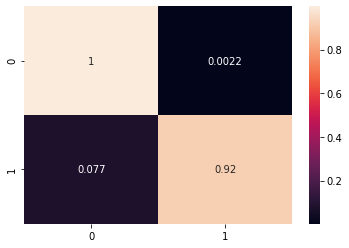

In [10]:
_ = evaluate(model, x_test, y_test)

Видно, что модель практически не пропускает ботов (лишь 7.7% ботов было классифицировано как пользователи). Однако условие лабораторной (порог пропуска бота в 3%) не выполняется.

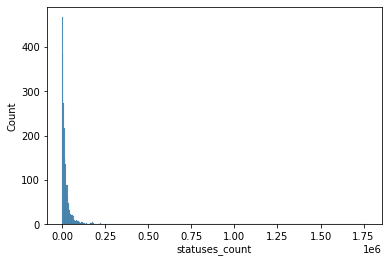

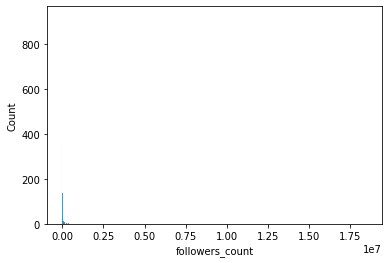

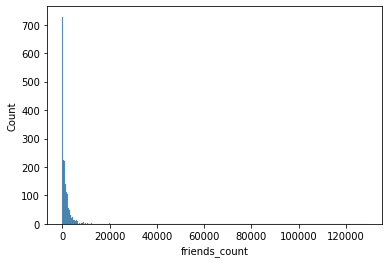

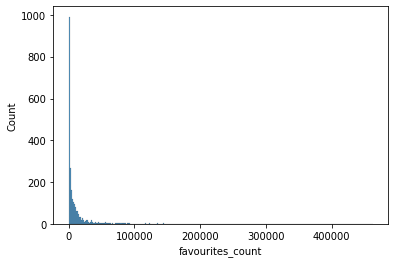

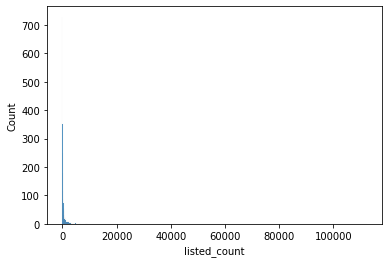

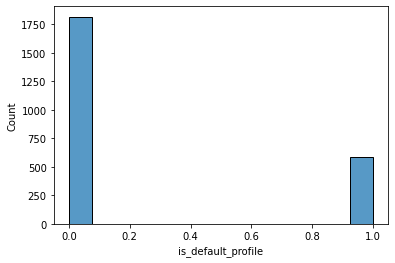

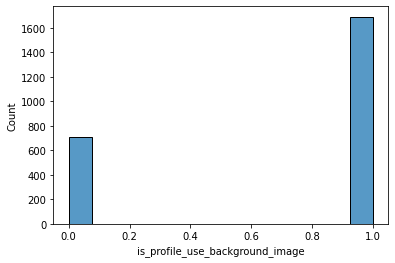

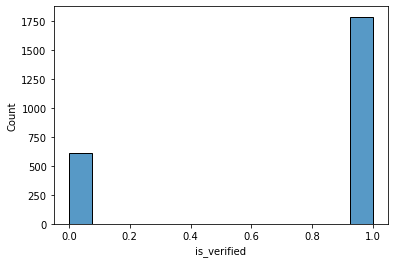

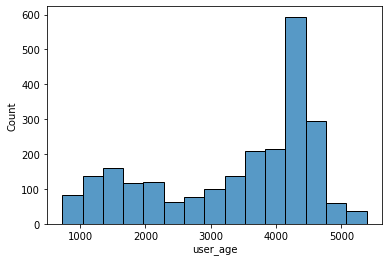

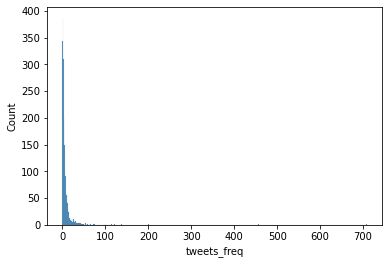

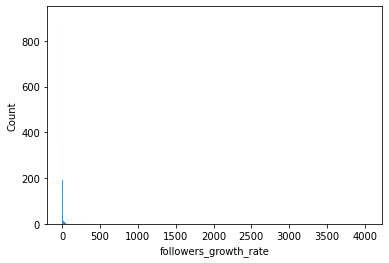

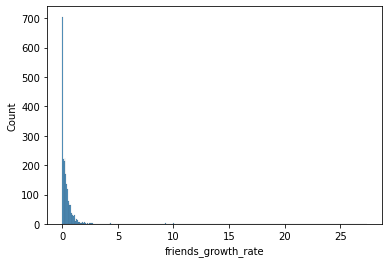

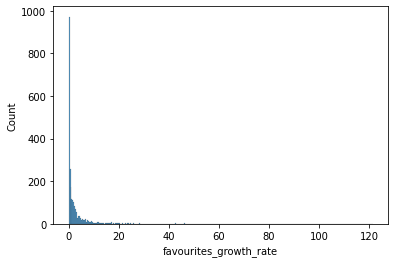

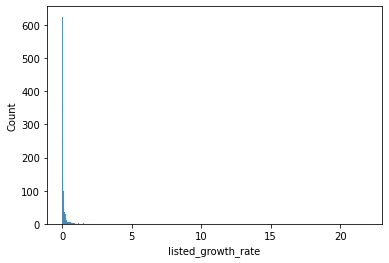

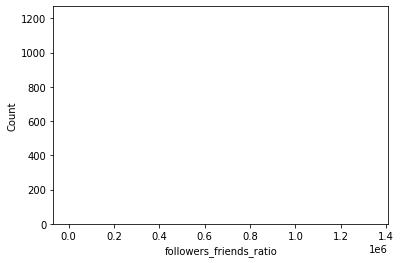

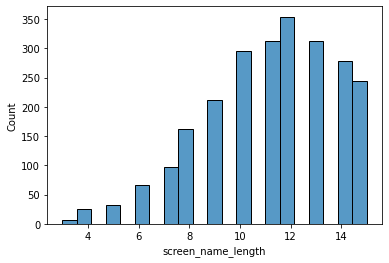

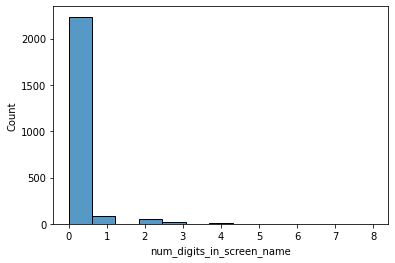

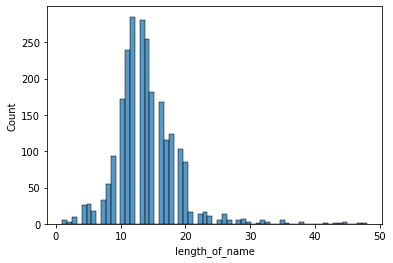

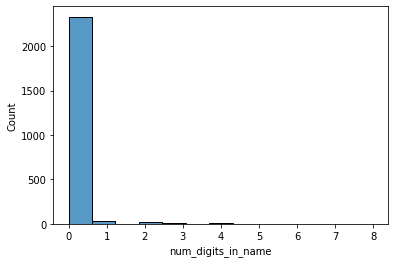

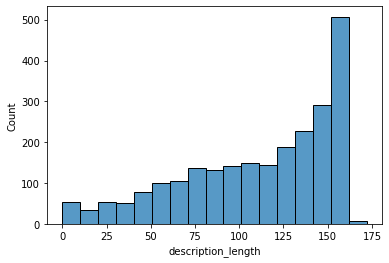

In [11]:
# Проанализируем распределение данных
for col in features.columns:
    plt.figure()
    sns.histplot(features[col], )

<AxesSubplot:ylabel='Count'>

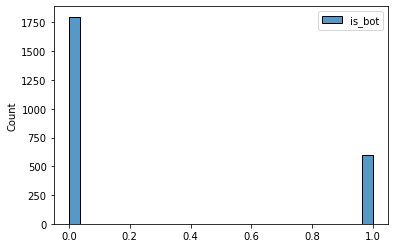

In [12]:
sns.histplot(labels)

1. Большое число признаков следует экспоненциальному распределению с большим значением лямбды - присутствуют сильные выбросы.
2. Классы не сбалансированы, обычных пользователей гораздо больше.

Попробуем убрать выбросы. Далее воспользуемся схожим пайплайном обработки выше с некоторыми изменениями: бинарные признаки не будут нормализоваться, для "экспоненциально распределенных" и небинарных будет применена нормализация сердним, ско и pca. Для балансировки классов будем использовать взвешивание во время обучения. Веса будут просчитываться как обратные частоты встречи классов.

In [13]:
exp_features = ['listed_growth_rate', 
                'favourites_growth_rate',
                'friends_growth_rate',
                'followers_growth_rate',
                'tweets_freq',
                'listed_count',
                'favourites_count',
                'friends_count',
                'followers_count',
                'statuses_count']

In [14]:
# Возьмём 95й перцентиль и установим порог на максимальное значение.
qt = features[exp_features].quantile(0.95)
print(qt)
new_features = features[exp_features].where(features[exp_features] < qt, qt, axis=1)

listed_growth_rate             0.614102
favourites_growth_rate        12.055496
friends_growth_rate            1.382397
followers_growth_rate         62.315315
tweets_freq                   26.499472
listed_count                2506.400000
favourites_count           46283.800000
friends_count               5550.150000
followers_count           253964.900000
statuses_count            102471.450000
Name: 0.95, dtype: float64


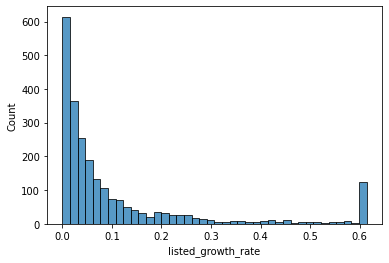

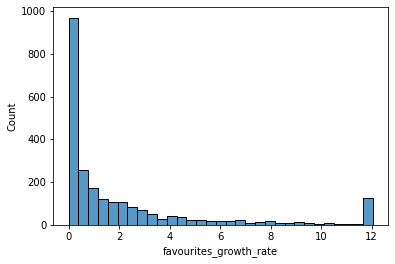

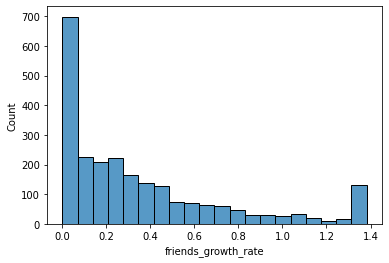

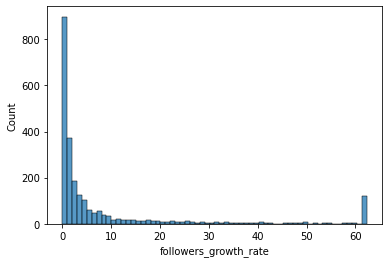

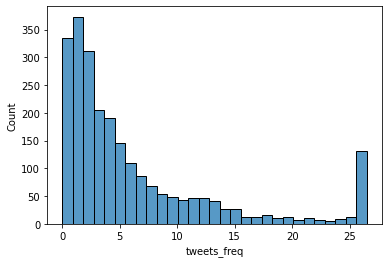

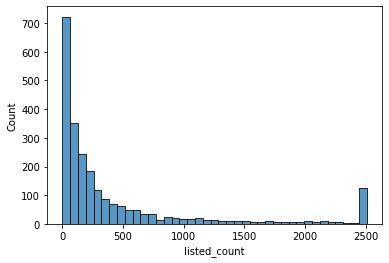

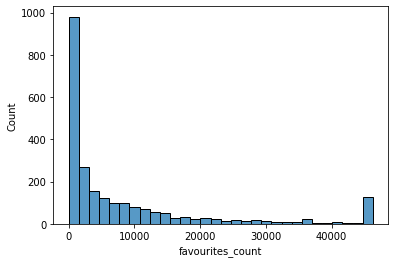

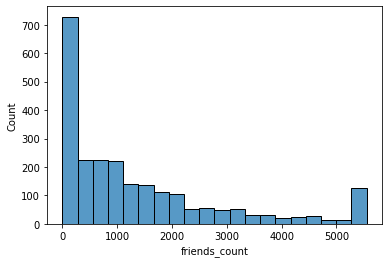

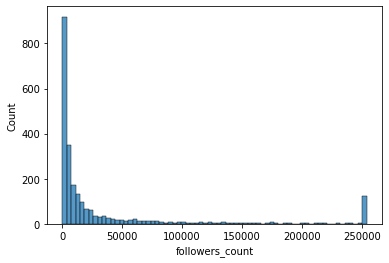

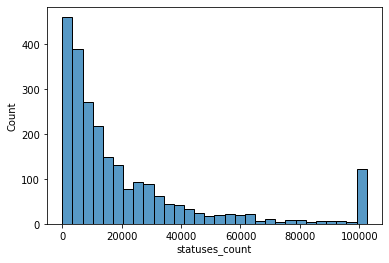

In [15]:
# Проанализируем распределение обработанных данных
for col in new_features.columns:
    plt.figure()
    sns.histplot(new_features[col], )

In [16]:
features1 = new_features.to_numpy()

In [17]:
other_features = set(features.columns) - set(exp_features)
binary_features = set(
    [
        'is_default_profile',
        'is_profile_use_background_image',
        'is_verified'
    ]
)
other_features = list(other_features - binary_features)

In [18]:
other_features

['num_digits_in_name',
 'user_age',
 'followers_friends_ratio',
 'screen_name_length',
 'description_length',
 'length_of_name',
 'num_digits_in_screen_name']

In [19]:
features2 = features[other_features].to_numpy()

In [20]:
features3 = features[binary_features].to_numpy()

<ipython-input-20-8d22965b501a>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features3 = features[binary_features].to_numpy()


In [21]:
features1_2 = np.concatenate([features1, features2], axis=1)

In [22]:
mean, std = features1_2.mean(axis=0), features1_2.std(axis=0)
features1_2 = (features1_2 - mean) / (std + 1e-3)

In [23]:
mean

array([1.10769510e-01, 2.15554185e+00, 3.48568152e-01, 8.64659599e+00,
       6.18942032e+00, 4.36391667e+02, 8.36439667e+03, 1.36513917e+03,
       3.41052717e+04, 2.16154667e+04, 5.91666667e-02, 3.38283708e+03,
       3.28404620e+03, 1.11795833e+01, 1.11012917e+02, 1.39237500e+01,
       1.18750000e-01])

In [24]:
pca2 = PCA(n_components=7).fit(features1_2)

In [25]:
features1_2_pca = pca2.transform(features1_2)

In [26]:
x_new = np.concatenate([features1_2_pca, features3], axis=1)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y)

In [28]:
cls_weights = {
               0: 1 / np.mean(y_train == 0),
               1: 1 / np.mean(y_train == 1)
               }

In [29]:
cls_weights

{0: 1.3235294117647058, 1: 4.090909090909091}

In [30]:
model = SVC(class_weight=cls_weights).fit(x_train, y_train)

f1-score: 0.98


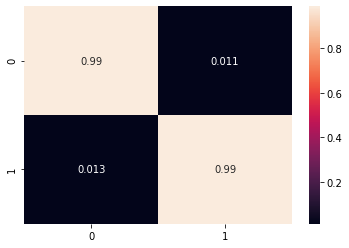

In [31]:
_ = evaluate(model, x_test, y_test)

Как видно из матрицы ошибок, модель пропустила лишь 1.3% ботов, т.о. условие задания выполнено. Делаем вывод, что примененный пайплайн обработки данных позволяет ощутимо увеличить качество модели.